### SIMAT encode

In [2]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.

import clip
import torch.nn as nn
from torchvision import datasets
import argparse
import torch
import pandas as pd
import numpy as np
from PIL import Image

import sys
import os
import wandb
import random
import numpy as np
from torchdata.datapipes.iter import FileLister, FileOpener, Decompressor

import sys

sys.path.append('/home/afahim2/tmp/clip-project/clipverse')

from src.config import training_hyperparameters
from src.evaluator import Evaluator

from src.config import *
from tqdm import tqdm
from dataset_processors.mscoco_processor import MSCOCOProcessor
from dataset_processors.cifar100_processor import CIFAR100Processor
from dataset_processors.cifar10_processor import CIFAR10Processor
from dataset_processors.imagenet_processor import ImageNet1k
from clips.clip_assembler import ClipAssembler

import clip
import torch
import torchvision.datasets as datasets
from functools import partial
from tqdm import tqdm
import pandas as pd
from pathlib import Path


In [48]:
cuda_device = 'cuda:0'
ROOT = '/home/afahim2/tmp/clip-project/clipverse'

In [58]:
selected_model = 'default'

In [59]:
paths = {
    'default': 'checkpoints/T0.01_Lit_44_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt',
    'cua': 'checkpoints/T0.01_Lituniform_align_44_finetune_I1C2E1E2_128_val_as_val_512_mscoco_VIT_pretrained_FINAL10.pt'
}

In [60]:
checkpoint_path = ROOT + '/' + paths[selected_model]

In [61]:
torch.Tensor.normalize = lambda x: x/x.norm(dim=-1, keepdim=True)

cuda_device = 'cuda:0'

device = cuda_device if torch.cuda.is_available() else "cpu"

model, prep = clip.load('ViT-B/32', device=device)

dim = 128


def simat_encode(clip_model, name='default'):
    # Copyright (c) 2015-present, Facebook, Inc.
    # All rights reserved.

    root = f'{ROOT}/datasets/simat/simat/'



    # code for encoding the SIMAT database with CLIP
    # produces the files data/simat_img_clip_2.pt and data/simat_words_clip_2.ptd

    DATA_PATH = root + 'simat_db/images/'
    CLIP_MODEL = 'ViT-B/32'

    model, prep = clip.load(CLIP_MODEL, device=device)



    ds = datasets.ImageFolder(DATA_PATH, transform=prep)

    dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=10, shuffle=False)

    img_enc = torch.cat([clip_model.encode_image(b.to(device)).cpu().detach() for b, i in tqdm(dl)]).float()

    fnames = [x[0].name for x in datasets.ImageFolder(DATA_PATH, loader=Path)]
    region_ids = [int(x[:-4]) for x in fnames]

    img_enc_mapping = dict(zip(region_ids, img_enc))
    torch.save(img_enc_mapping, root + f'data/simat_img_clip_{name}.pt')

    # encode words
    transfos = pd.read_csv( root + 'simat_db/transfos.csv', index_col=0)
    words = list(set(transfos.target) | set(transfos.value))

    # print('words: ', words)
    
    tokens = clip.tokenize(words).to(device)

    # print('tokens ', tokens)

    word_encs = clip_model.encode_text(tokens).cpu().detach()
    # word_encs = torch.cat([clip_model.encode_text(b.to(device)).cpu().detach() for b in tqdm(tokens.split(32))])

    w2we = dict(zip(words, word_encs))
    torch.save(w2we, root + f'data/simat_words_clip_{name}.ptd')

    
def simat_eval(name='default'):

    root = f'{ROOT}/datasets/simat/simat/'
    #img_head, txt_head, emb_key='clip', lbds=[1], test=True:, tau
    # get heads !
    emb_key = 'clip'
    # heads = torch.load(f'data/head_{emb_key}_t={args.tau}.pt')
    #heads = dict(img_head = lambda x:x, txt_head=lambda x:x)
    output = {}
    transfos = pd.read_csv(root + 'simat_db/transfos.csv', index_col=0)
    triplets = pd.read_csv(root + 'simat_db/triplets.csv', index_col=0)
    did2rid = dict(zip(triplets.dataset_id, triplets.index))
    rid2did = dict(zip(triplets.index, triplets.dataset_id))
    
    # transfos = transfos[transfos.is_test == (args.domain == 'test')]
    transfos = transfos[transfos.is_test == ('val' == 'test')]
    
    transfos_did = [rid2did[rid] for rid in transfos.region_id]
    
    #new method
    clip_simat = torch.load(root + f'data/simat_img_clip_{name}.pt')

    img_embs_stacked = torch.stack([clip_simat[did2rid[i]] for i in range(len(clip_simat))]).float().normalize()
    # img_embs_stacked = heads['img_head'](img_embs_stacked).normalize()
    value_embs = torch.stack([img_embs_stacked[did] for did in transfos_did])

    # img_embs_stacked  shape: (n, 64)
    
    
    word_embs = dict(torch.load(f'{root}data/simat_words_{emb_key}_{name}.ptd'))

    # w2v = {k:clip_model.encode_text(v.float()).float().cpu().detach().normalize() for k, v in word_embs.items()}
    # img_embs_stacked = heads['img_head'](img_embs_stacked).normalize()
    w2v = {k:v.float().normalize() for k, v in word_embs.items()}
    delta_vectors = torch.stack([w2v[x.target] - w2v[x.value] for i, x in transfos.iterrows()])
    
    oscar_scores = torch.load(root + 'simat_db/oscar_similarity_matrix.pt')
    weights = 1/np.array(transfos.norm2)**.5
    weights = weights/sum(weights)

    lbds = [1]
    
    # for lbd in args.lbds:
    for lbd in lbds:
        target_embs = value_embs + lbd*delta_vectors

        nnb = (target_embs @ img_embs_stacked.T).topk(5).indices
        nnb_notself = [r[0] if r[0].item() != t else r[1] for r, t in zip(nnb, transfos_did)]
        
        scores = np.array([oscar_scores[ri, tc] for ri, tc in zip(nnb_notself, transfos.target_ids)]) > .5

        
        output[lbd] = 100*np.average(scores, weights=weights)
    return output




training_hyperparameters['temperature'] = 0.01
training_hyperparameters['encoder1_modality'] = 'image'
training_hyperparameters['encoder2_modality'] = 'text'
training_hyperparameters['same_inputs'] = False
training_hyperparameters['clip_projection_dim'] = 128
training_hyperparameters['vision_model'] = 'VIT'
training_hyperparameters['use_train_as_val'] = False
training_hyperparameters['dataset'] = ClipDatasets.MSCOCO.value
training_hyperparameters['validation_dataset_size'] = 32
training_hyperparameters['validation_batch_size'] = 32
training_hyperparameters['use_small_trainloader'] = True
training_hyperparameters['small_train_loader_dataset_size'] = 32
training_hyperparameters['seed'] = 2
training_hyperparameters['train_from_scratch'] = True


training_hyperparameters['continue_from_checkpoint'] = False
training_hyperparameters['train_from_pretrained'] = True
training_hyperparameters['finetune_clip_backbone'] = True
training_hyperparameters['finetune_multi_layer_projection'] = False




wandb.init(config=training_hyperparameters, mode="disabled")


# set seed
torch.manual_seed(wandb.config['seed'])
random.seed(wandb.config['seed'])
np.random.seed(wandb.config['seed'])
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"


device = torch.device(config_cuda_device if torch.cuda.is_available() else "cpu")

clip_model = ClipAssembler().clip_model.to(device)


checkpoint = torch.load(checkpoint_path, map_location=device)
model_state_dict = checkpoint['model_state_dict']
clip_model.load_state_dict(model_state_dict)

simat_encode(clip_model, name=selected_model)
    



--- config_cuda_device = cuda:0 ---
setting projection dim to  128

--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda:0
check point path for CLIP model  checkpoints/T0.01_Lit_2_scratch_I1C2E1E2_128_val_as_val_32_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


/home/afahim2/miniconda3/envs/babylm/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 184/184 [00:19<00:00, 14.59it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/babylm/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/afahim2/miniconda3/envs/

### SIMAT infer

In [66]:
selected_model = 'cua'

checkpoint_path = ROOT + '/' + paths[selected_model]

--- config_cuda_device = cuda:0 ---
setting projection dim to  128

--- ENCODER 1 = IMAGE --- 


 --- Initializing CLIP Image Encoder from pretrained model ---


 --- Changing projection layer size of CLIP Image Encoder: VIT  to 128--- 


 --- Unfreezing backbone weights of CLIP Image Encoder: VIT  --- 


--- ENCODER 2 = TEXT --- 


 --- Initializing Text Encoder with CLIP tokenizer from pretrained model ---


 --- Changing projection layer size of Text Encoder with CLIP tokenizer to 128  --- 


 --- Unfreezing backbone weights of Text Encoder with CLIP tokenizer --- 

CLIP device  cuda:0
check point path for CLIP model  checkpoints/T0.01_Lit_2_scratch_I1C2E1E2_128_val_as_val_32_mscoco_VIT_pretrained_POST_PAPER.pt
CLIP model not loaded from checkpoint

--- HF CLIP MODEL ---

selected clip model  FINETUNED_TEMP
temperature (T):  0.01


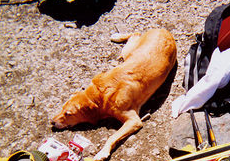

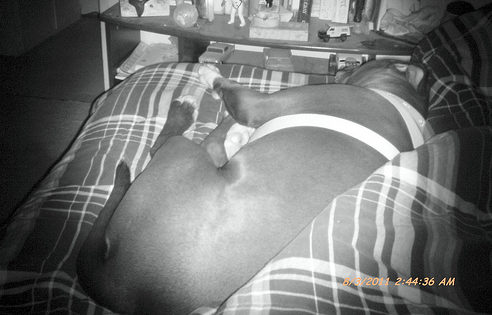

In [67]:
torch.Tensor.normalize = lambda x: x/x.norm(dim=-1, keepdim=True)

cuda_device = 'cuda:0'

device = cuda_device if torch.cuda.is_available() else "cpu"



def simat_infer(clip_model, name='default'):

    root = f'{ROOT}/datasets/simat/simat'
    # root = '/Volumes/SanDisk Extreme SSD Media/clipverse/datasets/simat/simat'

    # database to perform the retrieval step
    # dataset = datasets.ImageFolder(root + '/simat_db/images/')

    db = torch.load(root + f'/data/simat_img_clip_{name}.pt')
    db_stacked = torch.stack(list(db.values())).float()

    idx2rid = list(db.keys())


    _, prep = clip.load('ViT-B/32', device=device)

    model = clip_model

    image = Image.open(root + '/simat_db/images/images/41495.png')

    # 272

    image.show()
    img_enc = model.encode_image(prep(image).unsqueeze(0).to(device)).float().cpu().detach()

    txt = ['beach', 'bed']

    tokens = clip.tokenize(txt).to(device)

    
    txt_enc = model.encode_text(tokens).float().cpu().detach()

    # optionally, we can apply a linear layer on top of the embeddings
    # heads = torch.load(f'data/head_clip_t=0.1.pt')
    # img_enc = heads['img_head'](img_enc)
    # txt_enc = heads['txt_head'](txt_enc)

    # db = heads['img_head'](db).normalize()

    db = db_stacked.normalize()


    # now we perform the transformation step
    lbd = 1
    target_enc = img_enc.normalize() + lbd * (txt_enc[1].normalize() - txt_enc[0].normalize())


    retrieved_idx = (db_stacked @ target_enc.float().T).argmax(0).item()

    retrieved_rid = idx2rid[retrieved_idx]


    # display image

    # display(Image.open(f'{root}/simat_db/images/images/{retrieved_rid}.png'))
    Image.open(f'{root}/simat_db/images/images/{retrieved_rid}.png').show()



training_hyperparameters['temperature'] = 0.01
training_hyperparameters['encoder1_modality'] = 'image'
training_hyperparameters['encoder2_modality'] = 'text'
training_hyperparameters['same_inputs'] = False
training_hyperparameters['clip_projection_dim'] = 128
training_hyperparameters['vision_model'] = 'VIT'
training_hyperparameters['use_train_as_val'] = False
training_hyperparameters['dataset'] = ClipDatasets.MSCOCO.value
training_hyperparameters['validation_dataset_size'] = 32
training_hyperparameters['validation_batch_size'] = 32
training_hyperparameters['use_small_trainloader'] = True
training_hyperparameters['small_train_loader_dataset_size'] = 32
training_hyperparameters['seed'] = 2
training_hyperparameters['train_from_scratch'] = True


wandb.init(config=training_hyperparameters, mode="disabled")


# set seed
torch.manual_seed(wandb.config['seed'])
random.seed(wandb.config['seed'])
np.random.seed(wandb.config['seed'])
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"


device = torch.device(config_cuda_device if torch.cuda.is_available() else "cpu")

clip_model = ClipAssembler().clip_model.to(device)


checkpoint = torch.load(checkpoint_path, map_location=device)
model_state_dict = checkpoint['model_state_dict']
clip_model.load_state_dict(model_state_dict)

simat_infer(clip_model, name=selected_model)
    



